In [ ]:
!pip install ultralytics fiftyone opencv-python torch torchvision matplotlib


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 15.1 MB/s eta 

In [ ]:
# Install required packages (run once)
# !pip install ultralytics opencv-python torch torchvision matplotlib numpy

from ultralytics import YOLO
import cv2
import numpy as np
import os

# -----------------------------
# Step 1: Set dataset path
# -----------------------------
dataset_path = "/content/PKLot-1"  # your PKLot folder
yaml_file = os.path.join(dataset_path, "data.yaml")  # should exist and have correct relative paths

# -----------------------------
# Step 2: Initialize YOLOv8 model
# -----------------------------
model = YOLO("yolov8n.pt")  # nano for fast training, yolov8s.pt for higher accuracy

# -----------------------------
# Step 3: Train YOLOv8 model
# -----------------------------
model.train(
    data=yaml_file,
    epochs=10,   # increase for full training
    batch=8,
    imgsz=640,
    project="runs/train",
    name="PKLot_train",
    exist_ok=True
)

# -----------------------------
# Step 4: Evaluate model
# -----------------------------
metrics = model.val()
print("mAP@50:", metrics.box.map50)
print("Precision:", metrics.box.precision)
print("Recall:", metrics.box.recall)

# -----------------------------
# Step 5: Define sample parking slots
# -----------------------------
# Example: define 4 parking slots as polygons (x1,y1,x2,y2)
# Replace these coordinates with actual parking slot coordinates in your images
parking_slots = [
    [(50,50),(150,50),(150,150),(50,150)],
    [(200,50),(300,50),(300,150),(200,150)],
    [(50,200),(150,200),(150,300),(50,300)],
    [(200,200),(300,200),(300,300),(200,300)]
]

def polygon_iou(box, polygon):
    # Compute approximate IoU between bounding box and polygon
    # box = [x1,y1,x2,y2]
    # polygon = list of 4 points [(x,y),...]
    poly_x = [p[0] for p in polygon]
    poly_y = [p[1] for p in polygon]
    poly_x1, poly_y1 = min(poly_x), min(poly_y)
    poly_x2, poly_y2 = max(poly_x), max(poly_y)
    # intersection
    ix1 = max(box[0], poly_x1)
    iy1 = max(box[1], poly_y1)
    ix2 = min(box[2], poly_x2)
    iy2 = min(box[3], poly_y2)
    iw = max(ix2-ix1,0)
    ih = max(iy2-iy1,0)
    intersection = iw*ih
    box_area = (box[2]-box[0])*(box[3]-box[1])
    poly_area = (poly_x2-poly_x1)*(poly_y2-poly_y1)
    union = box_area + poly_area - intersection
    return intersection/union if union>0 else 0

# -----------------------------
# Step 6: Inference & Parking Occupancy
# -----------------------------
val_images_path = os.path.join(dataset_path, "valid/images")
val_images = os.listdir(val_images_path)[:5]  # first 5 images for demo

for img_name in val_images:
    img_path = os.path.join(val_images_path, img_name)
    img = cv2.imread(img_path)
    results = model.predict(source=img_path, conf=0.5)

    # Draw detected boxes
    for det in results[0].boxes.xyxy:
        x1,y1,x2,y2 = map(int, det)
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),2)  # red for car

    # Occupancy check
    for i, slot in enumerate(parking_slots):
        occupied = False
        for det in results[0].boxes.xyxy:
            box = list(map(int, det))
            if polygon_iou(box, slot) > 0.2:  # threshold IoU
                occupied = True
                break
        color = (0,0,255) if occupied else (0,255,0)  # red=occupied, green=free
        pts = np.array(slot, np.int32).reshape((-1,1,2))
        cv2.polylines(img,[pts],True,color,2)
        cv2.putText(img,f"Slot {i+1}",slot[0],cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    # Show result
    cv2.imshow("Parking Occupancy", img)
    cv2.waitKey(0)

cv2.destroyAllWindows()


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/PKLot-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=PKLot_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.
Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50: AP at IoU threshold of 0.5 for all classes.
        ap: AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mp: Mean precision of all classes.
        mr: Mean recall of all classes.
        map50: Mean AP at IoU threshold of 0.5 for all classes.
        map75: Mean AP at IoU threshold of 0.75 for all classes.
        map: Mean AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mean_results: Mean of results, returns mp, mr, map50, map.
        class_result: Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps: mAP of each class.
        fitness: Model fitness as a weighted combination of metrics.
        update: Update metric attributes with new evaluation results.
        curves: Provides a list of curves for accessing specific metrics like precision, recall, F1, etc.
        curves_results: Provide a list of results for accessing specific metrics like precision, recall, F1, etc.
    

In [ ]:
# -----------------------------
# Evaluate YOLOv8 (v8.3+)
# -----------------------------
metrics = model.val()  # returns DetMetrics object

# Mean metrics
print("Mean Precision (mp):", metrics.box.mp)
print("Mean Recall (mr):", metrics.box.mr)
print("mAP@50:", metrics.box.map50)
print("mAP@50-95:", metrics.box.map)

# Class-wise metrics
for i, class_name in metrics.names.items():  # use top-level metrics.names
    print(f"Class: {class_name}, Precision: {metrics.box.p[i]:.4f}, Recall: {metrics.box.r[i]:.4f}, mAP50: {metrics.box.ap50[i]:.4f}")


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1564.3±519.9 MB/s, size: 32.8 KB)
val: Scanning /content/PKLot-1/valid/labels.cache... 1618 images, 34 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1618/1618 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 102/102 3.2it/s 31.9s
                   all       1618      92808      0.976       0.98      0.994      0.914
           space-empty       1342      48551      0.964      0.987      0.994      0.924
        space-occupied       1286      44257      0.987      0.972      0.994      0.903
Speed: 1.2ms preprocess, 3.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val4
Mean Precision (mp): 0.9755764252173278
Mean Recall (mr): 0.9795679386141016
mAP@50: 0.9936694985804886
mAP@50-95: 0.9139563871423771
Class: space-empty, Precision: 0.9644, Rec

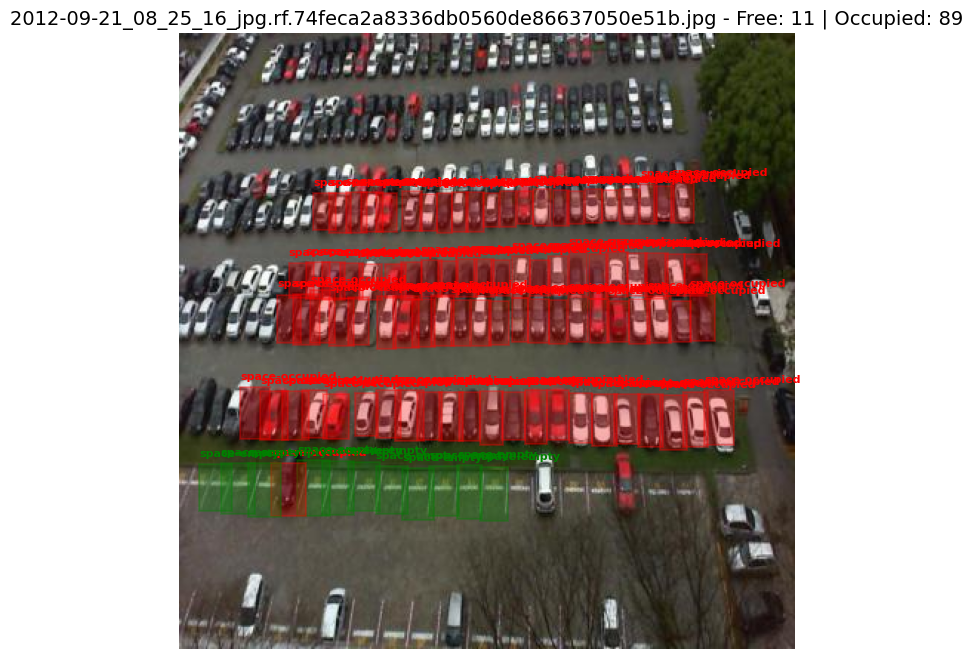

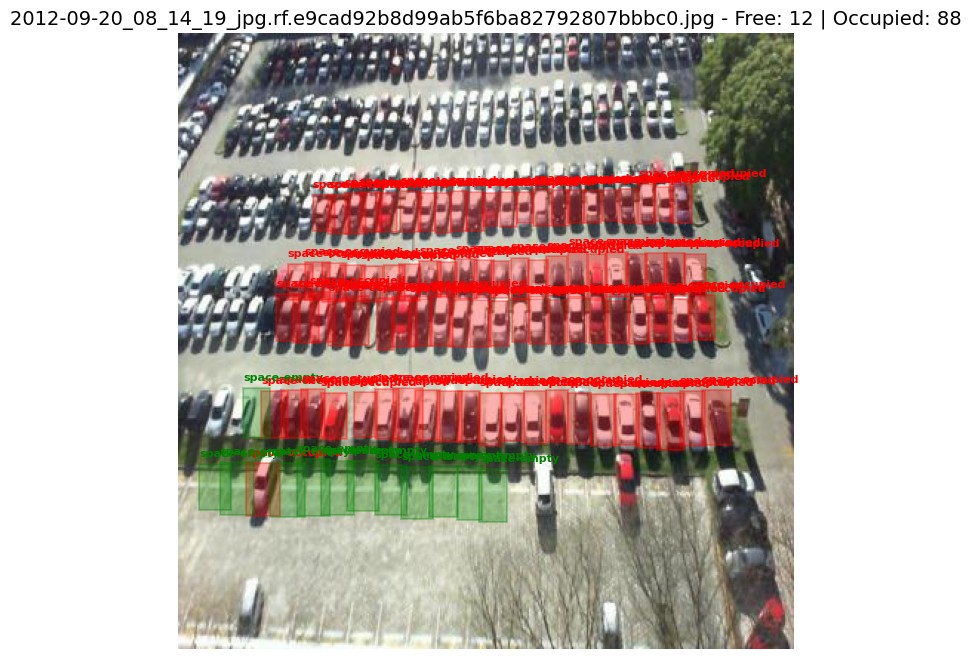

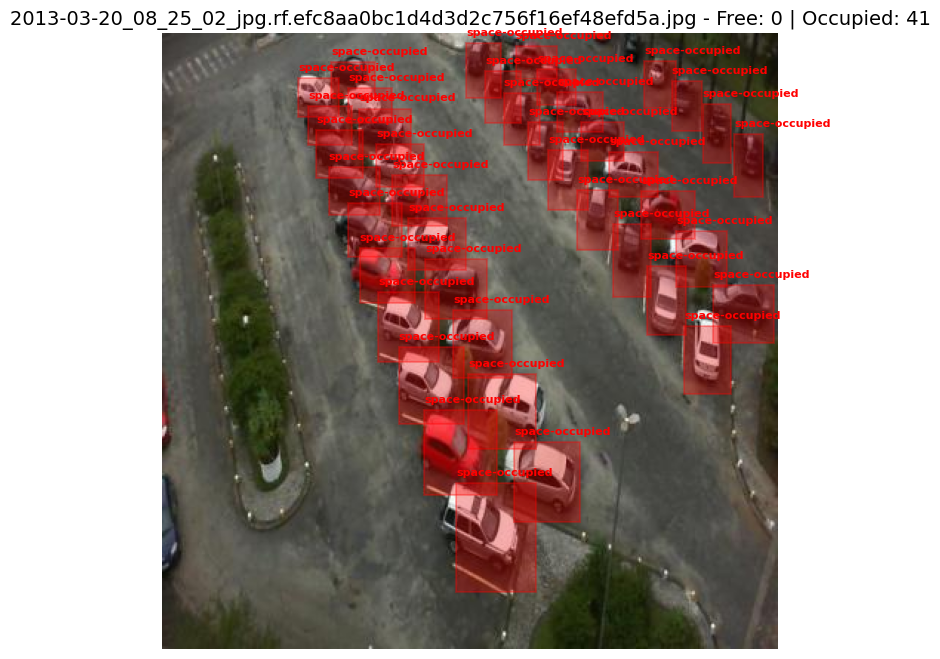

In [ ]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load trained YOLOv8 model
model_path = "/content/runs/train/PKLot_train/weights/best.pt"
model = YOLO(model_path)

val_images_path = "/content/PKLot-1/valid/images"
val_images = os.listdir(val_images_path)[:3]  # demo: first 3 images

class_names = ["space-empty", "space-occupied"]
colors = {"space-empty": "green", "space-occupied": "red"}  # free vs occupied

for img_name in val_images:
    img_path = os.path.join(val_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model.predict(source=img_path, conf=0.5, verbose=False)
    bboxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy().astype(int)

    # Plot using matplotlib
    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(img)

    occupied_count = 0
    free_count = 0

    for box, cls in zip(bboxes, classes):
        x1, y1, x2, y2 = box
        label = class_names[int(cls)]
        color = colors[label]
        if label=="space-occupied":
            occupied_count += 1
        else:
            free_count += 1

        # Add rectangle with transparency
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1.5,
                         edgecolor=color, facecolor=color, alpha=0.3)
        ax.add_patch(rect)
        ax.text(x1, y1-5, label, color=color, fontsize=8, weight='bold')

    # Title and legend
    ax.set_title(f"{img_name} - Free: {free_count} | Occupied: {occupied_count}", fontsize=14)
    ax.axis("off")
    plt.show()
